# Install Dependecies

In [1]:
# install torch depending on your cuda version
!pip install pandas
!pip install sentence-transformers
!pip install transformers
!pip install pillow
!pip install seaborn
!pip install openpyxl
!pip install ipywidgets
!pip install iprogress

# Imports

In [2]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
from io import BytesIO
from IPython.display import display, Image as IPImage
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch

# Load data

In [3]:
file_path = "wornwear.xlsx"
df = pd.read_excel(file_path)
df.head()

,motion-reduce src,card__badge,badge--sale,full-unstyled-link,full-unstyled-link href,card__color,price-item--current,price-item,price-item 2
0,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,Men's Better Sweater® Jacket,https://wornwear.patagonia.com/products/mens-b...,Stonewash,Sale,$72 - $95,$139
1,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,W's Better Sweater® Jacket,https://wornwear.patagonia.com/products/ws-bet...,Birch White,Sale,$59 - $74,$139
2,https://cdn.shopify.com/s/files/1/0751/2601/42...,NaN,NaN,W's Better Sweater® 1/4-Zip,https://wornwear.patagonia.com/products/ws-bet...,Birch White,NaN,$40 - $50,$99
3,https://cdn.shopify.com/s/files/1/0751/2601/42...,NaN,NaN,M's Better Sweater® 1/4-Zip,https://wornwear.patagonia.com/products/ms-bet...,Stonewash,NaN,$48 - $59,$99
4,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,M's Better Sweater® Jacket,https://wornwear.patagonia.com/products/ms-bet...,Black,Sale,$67 - $83,$139


## Download pictures

In [4]:
image_dir = "images"
os.makedirs(image_dir, exist_ok=True)

# download img from url
def download_image(url, save_dir, index):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            # If the image is in RGBA mode, it caan cause an error
            if img.mode == 'RGBA':
                # white background
                background = Image.new("RGB", img.size, (255, 255, 255))
                background.paste(img, mask=img.split()[3])  
                img = background
            image_path = os.path.join(save_dir, f"image_{index}.jpg")
            img.save(image_path)
            return image_path
        else:
            return None
    except Exception as e:
        print(f"Error downloading image {index}: {e}")
        return None

# iterate through the df and download
image_paths = []
for i, url in tqdm(enumerate(df.iloc[:, 0]), desc="Downloading Images", total=len(df)):
    image_path = download_image(url, image_dir, i)
    image_paths.append(image_path)

# add path to df
df['image_path'] = image_paths
df.head(2)


,motion-reduce src,card__badge,badge--sale,full-unstyled-link,full-unstyled-link href,card__color,price-item--current,price-item,price-item 2,image_path
0,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,Men's Better Sweater® Jacket,https://wornwear.patagonia.com/products/mens-b...,Stonewash,Sale,$72 - $95,$139,images\image_0.jpg
1,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,W's Better Sweater® Jacket,https://wornwear.patagonia.com/products/ws-bet...,Birch White,Sale,$59 - $74,$139,images\image_1.jpg


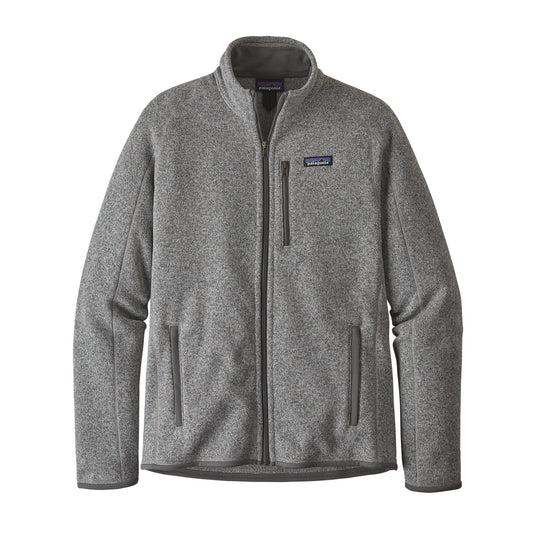

motion-reduce src          https://cdn.shopify.com/s/files/1/0751/2601/42...
card__badge                .badge--sale {\n        background-color: #000...
badge--sale                                                      Web Special
full-unstyled-link                              Men's Better Sweater® Jacket
full-unstyled-link href    https://wornwear.patagonia.com/products/mens-b...
card__color                                                        Stonewash
price-item--current                                                     Sale
price-item                                                         $72 - $95
price-item 2                                                            $139
Name: 0, dtype: object


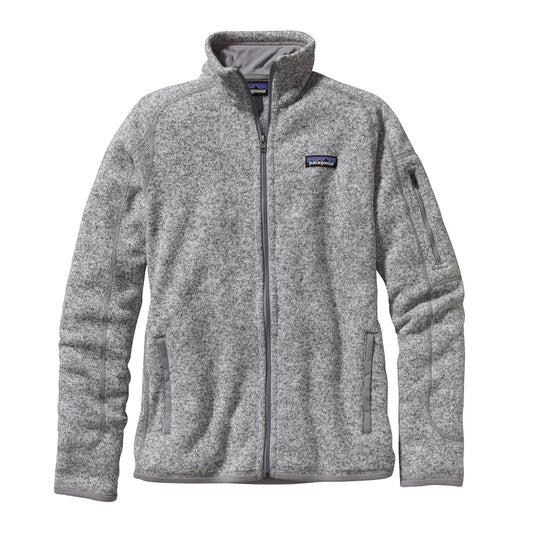

motion-reduce src          https://cdn.shopify.com/s/files/1/0751/2601/42...
card__badge                .badge--sale {\n        background-color: #000...
badge--sale                                                      Web Special
full-unstyled-link                                W's Better Sweater® Jacket
full-unstyled-link href    https://wornwear.patagonia.com/products/ws-bet...
card__color                                                      Birch White
price-item--current                                                     Sale
price-item                                                         $59 - $74
price-item 2                                                            $139
Name: 1, dtype: object


In [5]:
# display
for i, row in df.head(2).iterrows():
    display(IPImage(filename=row['image_path']))
    print(row.drop('image_path')) 

# Clean data

In [6]:
# remove none or missing rows
filtered_df = df.dropna(subset=['image_path', 'full-unstyled-link'])
print(f"Filtered DataFrame contains {len(filtered_df)} rows (removed {len(df) - len(filtered_df)} rows).")

df=filtered_df

Filtered DataFrame contains 96 rows (removed 0 rows).


# Initialisation

In [ ]:
# Load models <<These may be changed>>
text_model = SentenceTransformer('all-MiniLM-L6-v2')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# text embed
def get_text_embedding(text):
    return text_model.encode(text)

# img embed
def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_embedding = clip_model.get_image_features(**inputs)
        return image_embedding.squeeze().numpy()
    except Exception as e:
        print(f"Error processing image file: {image_path}, Error: {e}")
        return None

def normalize_embedding(embedding):
    norm = np.linalg.norm(embedding)
    if norm == 0:  # Min-max norm better ? 
        return embedding
    return embedding / norm

# init
text_embeddings = []
image_embeddings = []

for i, row in tqdm(df.iterrows(), desc="Generating Embeddings", total=len(df)):
    description = row['full-unstyled-link']  
    image_path = row['image_path']  

    # generate embed
    text_embed = get_text_embedding(description)
    image_embed = get_image_embedding(image_path)

    if text_embed is not None and image_embed is not None:
        text_embeddings.append(text_embed)
        image_embeddings.append(image_embed)

# Concat embed
item_embeddings = []
for text_embed, image_embed in zip(text_embeddings, image_embeddings):
    if text_embed is not None and image_embed is not None:
        # we normalize embeddings so neither of the text or image embeddings dominate the concat vector
        text_embed = normalize_embedding(text_embed)
        image_embed = normalize_embedding(image_embed)
        combined_embedding = np.concatenate([text_embed, image_embed])
        item_embeddings.append(combined_embedding)
    else:
        print("Invalid embedding ?!")


# Add embed to df
df['embedding'] = item_embeddings
df.head(5)


Generating Embeddings:   0%|          | 0/96 [00:00<?, ?it/s]

,motion-reduce src,card__badge,badge--sale,full-unstyled-link,full-unstyled-link href,card__color,price-item--current,price-item,price-item 2,image_path,embedding
0,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,Men's Better Sweater® Jacket,https://wornwear.patagonia.com/products/mens-b...,Stonewash,Sale,$72 - $95,$139,images\image_0.jpg,"[-0.047998305, 0.11091225, -0.010734149, 0.049..."
1,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,W's Better Sweater® Jacket,https://wornwear.patagonia.com/products/ws-bet...,Birch White,Sale,$59 - $74,$139,images\image_1.jpg,"[-0.07859272, 0.09179225, 0.02234178, 0.072813..."
2,https://cdn.shopify.com/s/files/1/0751/2601/42...,NaN,NaN,W's Better Sweater® 1/4-Zip,https://wornwear.patagonia.com/products/ws-bet...,Birch White,NaN,$40 - $50,$99,images\image_2.jpg,"[-0.060422786, 0.086901605, 0.0061385287, 0.05..."
3,https://cdn.shopify.com/s/files/1/0751/2601/42...,NaN,NaN,M's Better Sweater® 1/4-Zip,https://wornwear.patagonia.com/products/ms-bet...,Stonewash,NaN,$48 - $59,$99,images\image_3.jpg,"[-0.02961956, 0.079462916, 0.015003448, 0.0489..."
4,https://cdn.shopify.com/s/files/1/0751/2601/42...,.badge--sale {\n background-color: #000...,Web Special,M's Better Sweater® Jacket,https://wornwear.patagonia.com/products/ms-bet...,Black,Sale,$67 - $83,$139,images\image_4.jpg,"[-0.03966792, 0.0868756, 0.03142055, 0.0555229..."


# User Embeddings

##### TODO : Here we are showing some samples of the dataset to the user and he will like or dislike the items 

In [8]:
## sample num items of the dataset that we show to the user to get user preference embeds
num_items = 10
sample_indices = random.sample(range(len(df)), num_items)
sample_items = df.iloc[sample_indices]

#### TODO ....

In [9]:
# we suppose
user_likes=[0,2,8,13,22]
user_dislikes=[1,3,19,20,40]

In [10]:
# create and update user embeds
def update_user_profile(user_likes, user_dislikes, df):
    liked_embeddings = [df.iloc[idx]['embedding'] for idx in user_likes]
    disliked_embeddings = [df.iloc[idx]['embedding'] for idx in user_dislikes]

    # Calculate the user profile embedding
    user_profile = np.mean(liked_embeddings, axis=0)  # average liked
    
    dislike_weight = 0.5  # maybe needs to be changed ?
    if disliked_embeddings:
        user_profile -= dislike_weight * np.mean(disliked_embeddings, axis=0)

    return user_profile

user_profile = update_user_profile(user_likes, user_dislikes, df)
print("Welcome!")

Welcome!


# Recommendation

Recommended items:
Item: Men's Better Sweater® 1/4-Zip, Image Path: images\image_28.jpg


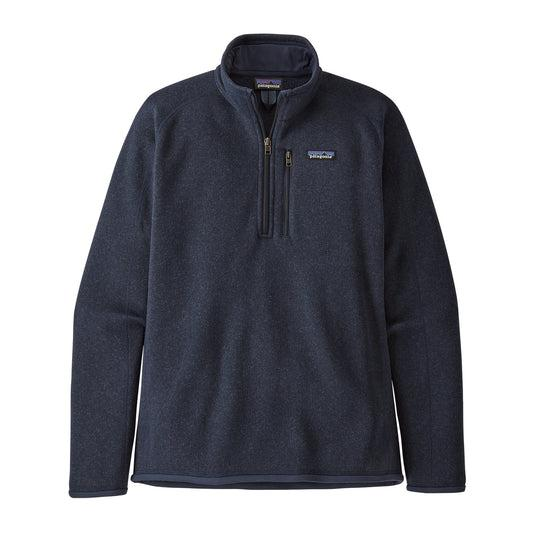

Item: Men's Better Sweater® Jacket, Image Path: images\image_95.jpg


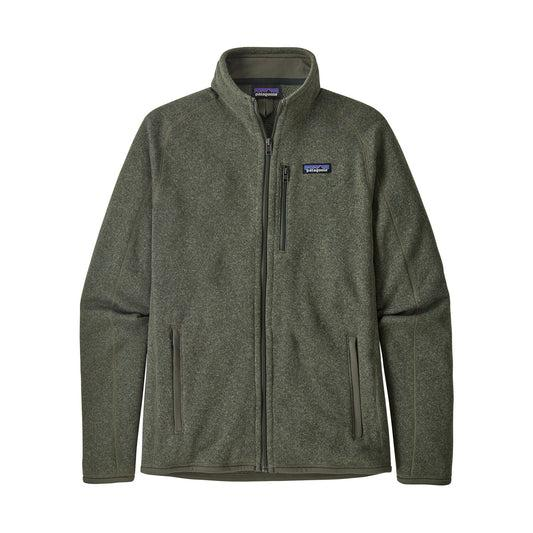

In [11]:
def retrieve_recommendations(user_profile, df, seen_indices, top_k=5):
    
    item_embeddings = np.array(df['embedding'].tolist())
    similarities = cosine_similarity([user_profile], item_embeddings)[0]

    # exclude seen items
    unseen_indices = [i for i in range(len(df)) if i not in seen_indices]
    unseen_similarities = similarities[unseen_indices]

    # top-k recomm
    top_k_indices = [unseen_indices[i] for i in np.argsort(unseen_similarities)[::-1][:top_k]]
    recommendations = df.iloc[top_k_indices]
    return recommendations

# TODO needs to be changed
seen_indices = [0,2,8,13,22,1,3,19,20,40]  

#number of recommendations
top_k = 2 
recommendations = retrieve_recommendations(user_profile, df, seen_indices, top_k)

print("Recommended items:")
for _, row in recommendations.iterrows():
    print(f"Item: {row['full-unstyled-link']}, Image Path: {row['image_path']}")
    display(IPImage(filename=row['image_path']))
